Repeat exercise 15 of Part 2 (text classification with mostly linear classifiers), now using
an MLP classifier implemented (by you) in TensorFlow.

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install --upgrade tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
!nvidia-smi

Mon Nov 20 18:29:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [5]:
import time
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model


# Dataset

In [6]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [7]:
def load_train_test_imdb_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    print(data["test"])
    return data["train"], data["test"]


In [8]:
import os

train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

                                                    text  sentiment
0      On the eighth day God created Georges. But the...          1
1      I remember watching this film in the eighties ...          0
2      Family is about two families who are after eac...          1
3      OK... this movie so far has been slated by cri...          1
4      This was fun to watch, spookily atmospheric an...          1
...                                                  ...        ...
24995  Play Mystery Theater 3000 at home with your fr...          0
24996  there was some truth to this movie. I remember...          0
24997  Powers Boothe turns in a stellar performance a...          1
24998  I was very excited to see that they had made a...          0
24999  I absolutely hate this programme, what kind of...          0

[25000 rows x 2 columns]
                                                    text  sentiment
0      Disney-like entertainment with some un-Disney-...          0
1      This is a nice 

In [9]:
train_data

,text,sentiment
0,On the eighth day God created Georges. But the...,1
1,I remember watching this film in the eighties ...,0
2,Family is about two families who are after eac...,1
3,OK... this movie so far has been slated by cri...,1
4,"This was fun to watch, spookily atmospheric an...",1
...,...,...
24995,Play Mystery Theater 3000 at home with your fr...,0
24996,there was some truth to this movie. I remember...,0
24997,Powers Boothe turns in a stellar performance a...,1
24998,I was very excited to see that they had made a...,0


In [10]:
test_data

,text,sentiment
0,Disney-like entertainment with some un-Disney-...,0
1,This is a nice movie with good performances by...,1
2,A highly original film using a myriad of genre...,1
3,"You can't really call Roy Andersson prolific, ...",1
4,Unusually cold and silly drama from director S...,0
...,...,...
24995,"First, let me confess that I have not read thi...",1
24996,No one can say I wasn't warned as I have read ...,0
24997,Amanda Bynes is an enormously talented actress...,0
24998,The story of Sweeney Todd evokes memories of t...,1


In [11]:
df = pd.concat([train_data, test_data], ignore_index=True)
df

,text,sentiment
0,On the eighth day God created Georges. But the...,1
1,I remember watching this film in the eighties ...,0
2,Family is about two families who are after eac...,1
3,OK... this movie so far has been slated by cri...,1
4,"This was fun to watch, spookily atmospheric an...",1
...,...,...
49995,"First, let me confess that I have not read thi...",1
49996,No one can say I wasn't warned as I have read ...,0
49997,Amanda Bynes is an enormously talented actress...,0
49998,The story of Sweeney Todd evokes memories of t...,1


In [12]:
x = df['text']
y = df['sentiment']

In [13]:
x

0        On the eighth day God created Georges. But the...
1        I remember watching this film in the eighties ...
2        Family is about two families who are after eac...
3        OK... this movie so far has been slated by cri...
4        This was fun to watch, spookily atmospheric an...
                               ...                        
49995    First, let me confess that I have not read thi...
49996    No one can say I wasn't warned as I have read ...
49997    Amanda Bynes is an enormously talented actress...
49998    The story of Sweeney Todd evokes memories of t...
49999    No,I'm not a radical feminst bashing the henta...
Name: text, Length: 50000, dtype: object

In [14]:
y

0        1
1        0
2        1
3        1
4        1
        ..
49995    1
49996    0
49997    0
49998    1
49999    0
Name: sentiment, Length: 50000, dtype: int64

# **Pre-Processing**

In [15]:
import nltk
nltk.download('wordnet')

import re
# Consult python regex docs for Regular Expression usage: https://docs.python.org/3/library/re.html

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
stemmer = WordNetLemmatizer()
docs = []

for doc in x:

    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    word_list = document.split()

    # Lemmatization
    word_list = [stemmer.lemmatize(word) for word in word_list]

    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(word_list)

    # Append all documents into a list 'docs'
    docs.append(document)

In [17]:
print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])


Original review text:
On the eighth day God created Georges. But the same as an eighth day doesn't fit into the week, Georges doesn't fit into the modern world: He has Down syndrome and is therefore marginalized by society, shunted off to an asylum after his mother's death four years ago. She was the only one who loved him.<br /><br />Harry is another man that isn't loved anymore. His wife has left him, for reasons that she is unable to explain. He loses the love of his daughters, too, when he arrives too late at the railway station to collect the two kids, who wanted to spend the weekend with their father.<br /><br />Harry is a highly ranked businessman. He knows all the rules that enable us to succeed in our modern meritocracy. But he has entered a state of crisis, which reaches a climax after the loss of the love of his daughters. He questions the sense of his life, without obtaining any definite results.<br /><br />Harry and Georges meet. At first Harry tries to get rid of Georges

# **Split dataset**
In the data preprocessing phase, the dataset was partitioned into training, development, and test sets using the train_test_split function from the scikit-learn library, ensuring a representative distribution of sentiment across the subsets. This systematic division allowed for independent model training on the training set, hyperparameter tuning on the development set, and unbiased evaluation on the test set, fostering a robust analysis of model generalization.

## Training Set

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=23828748)

In [32]:
len(x_train)

35000

## Development Set

In [33]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [34]:
len(x_dev)

5250

In [35]:
# Calculate the number of documents in each set
num_training_documents = len(x_train)
num_dev_documents = len(x_dev)
num_test_documents = len(x_test)

# Print he results
print(f"Number of Training Documents: {num_training_documents}")
print(f"Number of Development Documents: {num_dev_documents}")
print(f"Number of Test Documents: {num_test_documents}")

Number of Training Documents: 29750
Number of Development Documents: 5250
Number of Test Documents: 15000


## Test Set

In [36]:
len(x_test)

15000

# Tokenization

In [38]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_text(text):
    doc = nlp(text)  # Tokenize the text into sentences
    tokens = []

    for sent in doc.sents:
        for tok in sent:  # Iterate through the words of the sentence
            # Skip non-useful tokens
            if (
                '\n' in tok.text or
                "\t" in tok.text or
                "--" in tok.text or
                "*" in tok.text or
                tok.text.lower() in STOP_WORDS
            ):
                continue

            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())

    return tokens

In [40]:
X_train_tokenized = [tokenize_text(text) for text in x_train]
X_dev_tokenized = [tokenize_text(text) for text in x_dev]
X_test_tokenized = [tokenize_text(text) for text in x_test]

In [41]:
for item in X_train_tokenized[:2]:
  print(item, '\n')

['second', 'episode', 'new', 'lost', 'fan', 'lacking', 'fair', 'riveting', 'action', 'scene', 'seeing', 'brand', 'new', 'feature', 'weren', 'expecting', 'encounter', 'best', 'proof', 'series', 'ingoing', '4th', 'season', 'alive', 'kicking', 'hard', 'br', 'br', 'producer', 'don', 'amaze', 'u', 'flash', 'forward', 'time', 'return', 'flashback', 'satisfying', 'brings', 'shocking', 'fact', 'flashback', 'introduce', 'fresh', 'character', 'familiar', 'turn', 'connected', 'surprising', 'way', 'br', 'br', 'fresh', 'character', 'dominate', 'episode', 'doe', 'harm', 'scenario', 'actor', 'extremely', 'providing', 'u', 'bracing', 'feel', 'right', 'episode', 'll', 'realize', 'needed', 'people', 'like', 'br', 'br', 'confirmed', 'dead', 'gripping', 'action', 'greatly', 'written', 'dialogue', 'm', 'sure', 'll', 'quote', 'best', 'scene', 'episode', 'long', 'time', 'good', 'remain', 'spectator', 'mind', 'episode', 'entertaining', 'smart', 'perky', 'like', 'lost', 'watch', 'vote'] 

['lucio', 'fulci', 'd

# Training Preparation

## TF-IDF

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
# Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_dev_tfidf = vectorizer.transform([" ".join(x) for x in X_dev_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape)

(29750, 5000)


## SVD

In [83]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_dev_svd = svd.transform(X_dev_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## 1-hot Vectors

In [137]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
target_list = [0,1]

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))
print('y_dev_1_hot[0]: {}'.format(y_dev_1_hot[0]))

y_train_1_hot[0]: [1]
y_dev_1_hot[0]: [0]


In [136]:
y_test

44304    0
30168    1
44248    1
32548    1
19712    0
        ..
36619    0
49677    0
1143     0
19280    1
2851     0
Name: sentiment, Length: 15000, dtype: int64

# Evaluation Preparation

In [88]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

# Baseline Models

In [110]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a majority classifier that always predicts the most frequent class
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(X_train_svd, y_train)

# Make predictions on the development set
predictions_majority = majority_classifier.predict(X_dev_svd)

# Define target names based on your specific class labels
target_names = ["0", "1"]

# Print the classification report for the majority classifier
print("Majority Classifier:")
print(classification_report(y_dev, predictions_majority, target_names=target_names))


Majority Classifier:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2611
           1       0.00      0.00      0.00      2639

    accuracy                           0.50      5250
   macro avg       0.25      0.50      0.33      5250
weighted avg       0.25      0.50      0.33      5250



In [111]:
from sklearn.metrics import accuracy_score
predictions = majority_classifier.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = majority_classifier.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 49.73%
Test Accuracy:49.99%


In [91]:
print("X_train_svd shape:", X_train_svd.shape)
print("y_train_1_hot shape:", y_train_1_hot.shape)


X_train_svd shape: (29750, 500)
y_train_1_hot shape: (29750, 1)


# MLP Classifier

In [130]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
    input_dim = X_train_svd.shape[1]

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    # Print model summary to verify the architecture
    print(model.summary())

    # Configures the model for training.
    model.compile(
        loss='binary_crossentropy',  # Change to binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )

    start_training_time = time.time()
    history = model.fit(
        X_train_svd,
        y_train_1_hot,
        validation_data=(X_dev_svd, y_dev_1_hot),
        batch_size=256,
        epochs=100,
        shuffle=True,
        callbacks=[checkpoint]
    )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               64128     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 72449 (283.00 KB)
Trainable params: 72449 (283.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100

# Visualize History

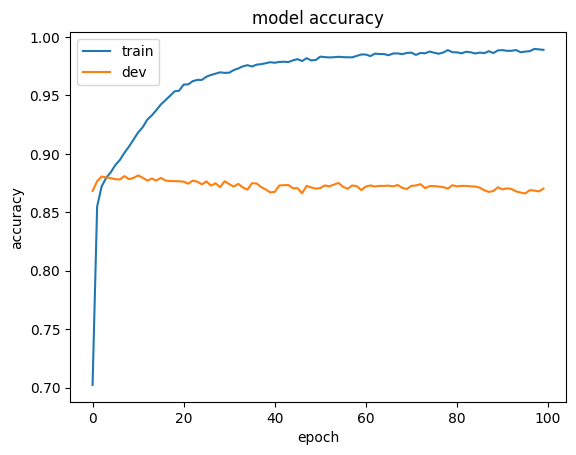

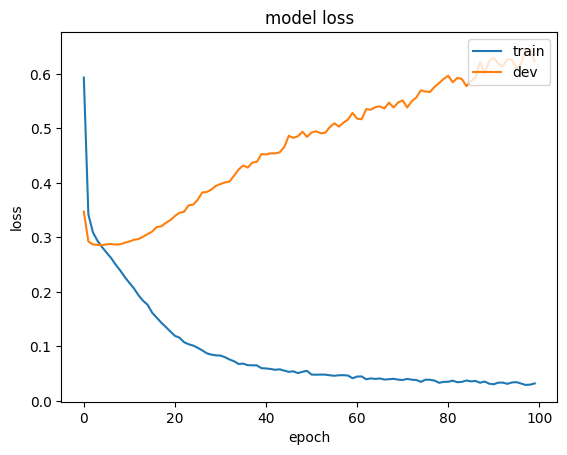

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [144]:
import time
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming you have X_train_svd, y_train_1_hot, X_dev_svd, y_dev_1_hot, X_test_svd, y_test_1_hot

with tf.device('/device:GPU:0'):
    input_dim = X_train_svd.shape[1]

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Print model summary to verify the architecture
    print(model.summary())

    # Configures the model for training.
    model.compile(
        loss='binary_crossentropy',  # Change to binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    start_training_time = time.time()
    history = model.fit(
        X_train_svd,
        y_train_1_hot,
        validation_data=(X_dev_svd, y_dev_1_hot),
        batch_size=256,
        epochs=100,  # You can adjust the number of epochs
        shuffle=True,
        callbacks=[checkpoint, early_stopping]
    )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_svd, y_test_1_hot)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               64128     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 72449 (283.00 KB)
Trainable params: 72449 (283.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10

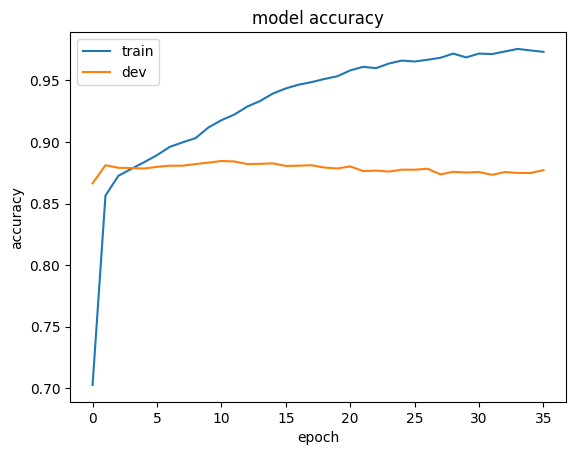

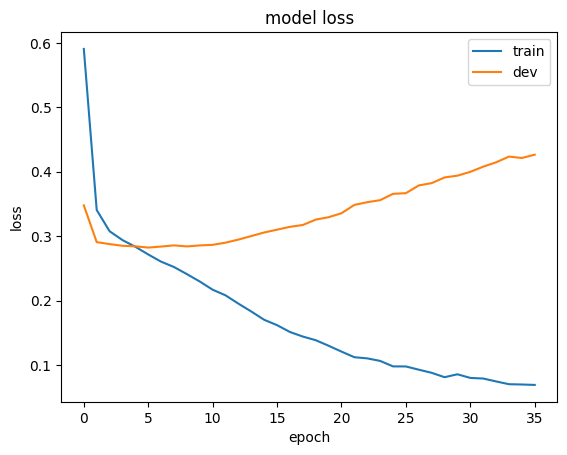

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()